# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision import utils
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import torchvision.models
import PIL
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
sns.set_style("dark")

# Data Visualization

In [3]:
l="abcdefghijklmnopqrstuvwxyz".upper()
n=range(26)
label_to_class=dict(zip(n,l))

label_to_class[26]="del"
label_to_class[27]="nothing"
label_to_class[28]="space"

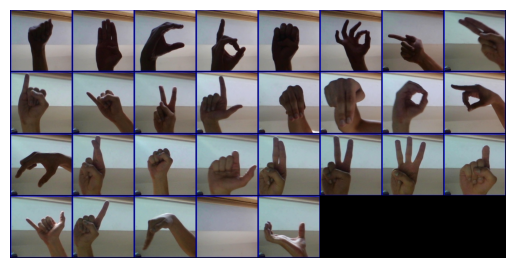

In [4]:
root="/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
imgs=[]
labels=[]

for i in range(29):
    
    cls_directory=os.path.join(root,label_to_class[i])
    image_path=os.path.join(cls_directory,label_to_class[i]+"1.jpg")
    img=Image.open(image_path)
    img=TF.to_tensor(img)
    imgs.append(img)
    labels.append(label_to_class[i])
    
imgs=utils.make_grid(imgs,nrow=8)
np.array(imgs)
imgs=np.transpose(np.array(imgs),(1,2,0))
plt.imshow(imgs);
plt.axis("off");
plt.savefig("1.jpg")

# Dataset

In [5]:
root="/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

#ImageNet Dataset mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data=datasets.ImageFolder(root, transform=transforms.Compose([transforms.Resize(224),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize(mean,std)]))

In [6]:
def show(imgs):
    imgs=np.array(imgs)
    imgs=imgs.transpose(1,2,0)*std+mean
    imgs=np.clip(imgs,0,1)
    plt.imshow(imgs)
    plt.axis("off")

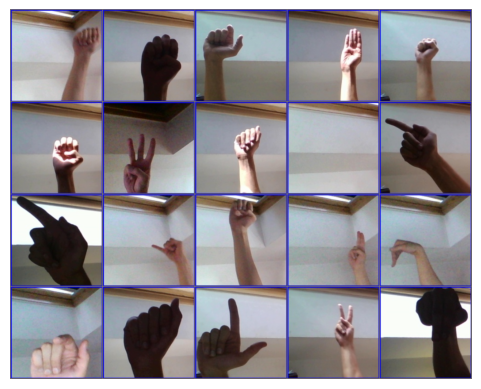

In [7]:
indexs=np.random.choice(range(len(data)),20,replace=False)

imgs=[data[i][0] for i in indexs]
labels=[data[i][1] for i in indexs]

imgs=utils.make_grid(imgs,nrow=5)
show(imgs)
plt.savefig("2.jpg")

# Dataloader

In [8]:
train_idx,val_idx=train_test_split(range(len(data)),test_size=0.4)

train_ds=Subset(data,train_idx)
val_ds=Subset(data,val_idx)

train_dl=DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=2)
val_dl=DataLoader(val_ds,batch_size=16,shuffle=True,num_workers=2)

# Model

In [9]:
from torchvision.models import vgg11_bn,VGG11_BN_Weights

In [10]:
vgg=vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:13<00:00, 40.5MB/s]


In [11]:
class VGG(nn.Module):
    def __init__(self,out_features):
        super().__init__()
        
        self.out_features=out_features
        self.in_features=list(vgg.children())[2][-1].in_features
        
        self.body=nn.Sequential(*list(vgg.children())[:-1])
        self.head=nn.Sequential(*list(vgg.children())[2][:-1])
        
        self.classification=nn.Linear(self.in_features,self.out_features)
        
    def forward(self,x):
        x=self.body(x)
        x=x.view(x.size(0),-1)
        x=self.head(x)
        x=self.classification(x)
        
        return x

In [12]:
device=("cuda" if torch.cuda.is_available() else "cpu")

model=VGG(len(label_to_class))
model.to(device)

for params in list(model.parameters())[:-2]:
    params.requires_grad=False

In [13]:
loss_fn=nn.CrossEntropyLoss(reduction="sum")
optim=torch.optim.Adam(list(model.parameters())[-2:],lr=0.0001)

# Training

In [14]:
losses={"train_loss":[],"val_loss":[],"train_metric":[],"val_metric":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)
epochs=15

for i in range(epochs):
    model.train()
    
    train_loss=0.0
    train_accuracy=0.0
    val_loss=0.0
    val_accuracy=0.0
    
    for x,y in train_dl:
        x,y=x.to(device),y.to(device)
        pred=model(x)
        loss=loss_fn(pred,y)
        
        train_loss+=loss_fn(pred,y).item()
        pred_labels=pred.argmax(dim=1)
        train_accuracy+=(pred_labels==y).sum().item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    model.eval()
    with torch.no_grad():
        for x,y in val_dl:
            x,y=x.to(device),y.to(device)
            pred=model(x)
            loss=loss_fn(pred,y)
            
            val_loss+=loss_fn(pred,y).item()
            pred_labels=pred.argmax(dim=1)
            val_accuracy+=(pred_labels==y).sum().item()
            
    print(f"{i+1}/{epochs} Epoch: \n\n train loss:{train_loss/train_len} \n val loss: {val_loss/val_len} \n")
    print(f"train accuracy:{train_accuracy/train_len} \n val accuracy: {val_accuracy/val_len} \n")
    print("*"*30+"\n")
            
    losses["train_loss"].append(train_loss/train_len)
    losses["val_loss"].append(val_loss/val_len)
    losses["train_metric"].append(train_accuracy/train_len)
    losses["val_metric"].append(val_accuracy/val_len)

1/15 Epoch: 

 train loss:1.4049815665670737 
 val loss: 0.5936714406465662 

train accuracy:0.6631609195402299 
 val accuracy: 0.8839080459770114 

******************************

2/15 Epoch: 

 train loss:0.7707769962540075 
 val loss: 0.3906969784970941 

train accuracy:0.7850191570881226 
 val accuracy: 0.911235632183908 

******************************

3/15 Epoch: 

 train loss:0.6370130143157595 
 val loss: 0.305783156839938 

train accuracy:0.8130268199233717 
 val accuracy: 0.9325574712643678 

******************************

4/15 Epoch: 

 train loss:0.5724273961953733 
 val loss: 0.2615939560309909 

train accuracy:0.8286590038314177 
 val accuracy: 0.9395977011494253 

******************************

5/15 Epoch: 

 train loss:0.5331395536301465 
 val loss: 0.2288956556863141 

train accuracy:0.8385057471264368 
 val accuracy: 0.945 

******************************

6/15 Epoch: 

 train loss:0.5045615601499647 
 val loss: 0.20729030082451885 

train accuracy:0.84141762452107

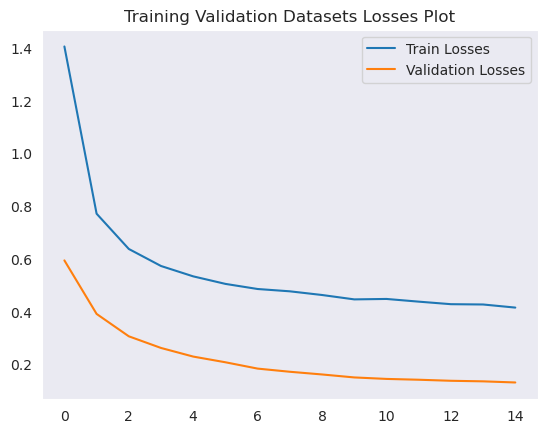

In [15]:
sns.lineplot(x=range(epochs),y=losses['train_loss'],label="Train Losses");
sns.lineplot(x=range(epochs),y=losses['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();
plt.savefig("3.jpg")

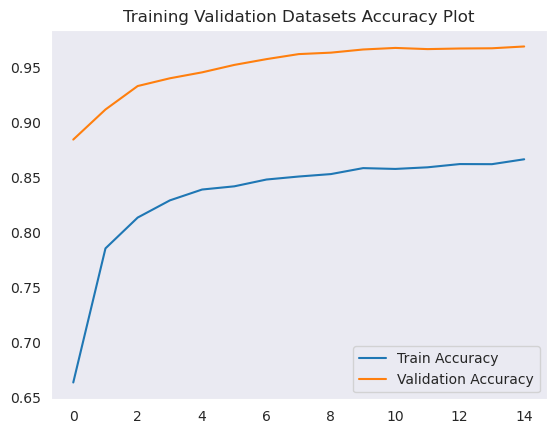

In [16]:
sns.lineplot(x=range(epochs),y=losses['train_metric'],label="Train Accuracy");
sns.lineplot(x=range(epochs),y=losses['val_metric'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();
plt.savefig("4.jpg")

# Saving Model parameters

In [17]:
torch.save(model.state_dict(),"model.pth")

In [18]:
results=pd.DataFrame(losses)
results.to_csv("solution.csv",index=False)

In [19]:
summary=pd.read_csv("/kaggle/working/solution.csv")
summary.head()

,train_loss,val_loss,train_metric,val_metric
0,1.404982,0.593671,0.663161,0.883908
1,0.770777,0.390697,0.785019,0.911236
2,0.637013,0.305783,0.813027,0.932557
3,0.572427,0.261594,0.828659,0.939598
4,0.533140,0.228896,0.838506,0.945000


# Model Deployment

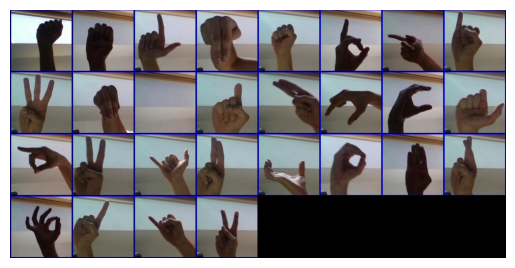

In [20]:
root="/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"
imgs=[]
labels=[]

for file in os.listdir(root):
    image_path=os.path.join(root,file)
    img=Image.open(image_path)
    img=TF.to_tensor(img)
    imgs.append(img)
    labels.append(file.split("_")[0])
    
grid=utils.make_grid(imgs,nrow=8)
grid=np.transpose(np.array(grid),(1,2,0))
plt.imshow(grid);
plt.axis("off");

In [21]:
model=VGG(len(label_to_class)).to(device)
model.load_state_dict(torch.load("/kaggle/working/model.pth"))

<All keys matched successfully>

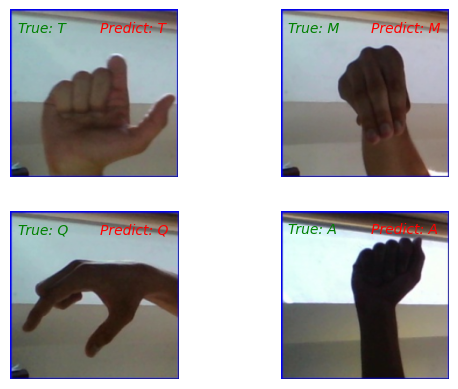

In [22]:
fig,axes=plt.subplots(2,2)
ax=axes.flatten()

indexs=np.random.choice(range(28), size=4, replace=False)

for i,idx in enumerate(indexs):
    img=imgs[idx]
    label=labels[idx]
    img=TF.to_pil_image(img)
    img=TF.resize(img,224)
    img=TF.to_tensor(img)
    img=TF.normalize(img,mean,std)
    img_gpu=img.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output=model(img_gpu)
        pred_label=label_to_class[torch.argmax(output,1).item()]
        
    ax[i].imshow(np.transpose((np.array(img)),(1,2,0))*std+mean)
    ax[i].text(10,30,"True: "+ label,style ='italic',
               fontsize = 10, color ="green")
    ax[i].text(120,30,"Predict: "+ pred_label,style ='italic',
                fontsize = 10, color ="red")
    ax[i].axis("off")
    
plt.savefig("5.jpg")